# Download Dataset dari Kaggle

In [1]:
!pip install kaggle -q      
!rm -rf /root/.kaggle.    
!mkdir /root/.kaggle       
!mv kaggle.json /root/.kaggle/kaggle.json   
!ls /root/.kaggle/kaggle.json
!kaggle datasets download -d ashishsaxena2209/animal-image-datasetdog-cat-and-panda

mkdir: cannot create directory ‘/root/.kaggle’: File exists
mv: cannot stat 'kaggle.json': No such file or directory
/root/.kaggle/kaggle.json
animal-image-datasetdog-cat-and-panda.zip: Skipping, found more recently modified local copy (use --force to force download)


# Unzip File

In [2]:
import zipfile
zip_ref = zipfile.ZipFile('/content/animal-image-datasetdog-cat-and-panda.zip', 'r')
zip_ref.extractall('tmp')
zip_ref.close()

# Membuat File Dataframe

In [3]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks import EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential

In [4]:
image_dir = Path('/content/tmp/animals/animals')

In [5]:
filepaths = list(image_dir.glob(r'**/*.jpg'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

In [6]:
image_df = pd.concat([filepaths, labels], axis=1)

In [7]:
image_df['Label'] = image_df['Label'].apply(lambda x: np.NaN if x[-2:] == 'GT' else x)
image_df = image_df.dropna(axis=0)

In [8]:
image_df

,Filepath,Label
0,/content/tmp/animals/animals/panda/panda_00207...,panda
1,/content/tmp/animals/animals/panda/panda_00888...,panda
2,/content/tmp/animals/animals/panda/panda_00788...,panda
3,/content/tmp/animals/animals/panda/panda_00908...,panda
4,/content/tmp/animals/animals/panda/panda_00491...,panda
...,...,...
2995,/content/tmp/animals/animals/dogs/dogs_00543.jpg,dogs
2996,/content/tmp/animals/animals/dogs/dogs_00665.jpg,dogs
2997,/content/tmp/animals/animals/dogs/dogs_00369.jpg,dogs
2998,/content/tmp/animals/animals/dogs/dogs_00688.jpg,dogs


In [9]:
image_df['Label'].value_counts()

panda    1000
cats     1000
dogs     1000
Name: Label, dtype: int64

# Split Training dan Testing

In [12]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function = tf.keras.applications.vgg16.preprocess_input,
    validation_split=0.2
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function = tf.keras.applications.vgg16.preprocess_input,
    validation_split=0.2
)

In [15]:
train_images = train_generator.flow_from_dataframe(
    dataframe=image_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = test_generator.flow_from_dataframe(
    dataframe=image_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False,
    subset='validation'
)

Found 2400 validated image filenames belonging to 3 classes.
Found 600 validated image filenames belonging to 3 classes.


# Membuat Model

In [16]:
model=Sequential()

In [17]:
model.add(tf.keras.applications.VGG16(include_top=False, pooling='avg', weights='imagenet',))

In [18]:
model.add(layers.Dense(3, activation='softmax'))
model.layers

In [19]:
model.layers[0].layers

In [20]:
model.layers[0].trainable=False
model.compile(loss='categorical_crossentropy',
              optimizer=tf.optimizers.Adam(),
              metrics=['accuracy'])

In [21]:
history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=100,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=3,
            restore_best_weights=True
        )
    ]
)

Epoch 1/100
75/75 [==============================] - 28s 303ms/step - loss: 0.7983 - accuracy: 0.8454 - val_loss: 0.3379 - val_accuracy: 0.9183
Epoch 2/100
75/75 [==============================] - 19s 249ms/step - loss: 0.1823 - accuracy: 0.9521 - val_loss: 0.2225 - val_accuracy: 0.9417
Epoch 3/100
75/75 [==============================] - 19s 257ms/step - loss: 0.1099 - accuracy: 0.9692 - val_loss: 0.1102 - val_accuracy: 0.9750
Epoch 4/100
75/75 [==============================] - 21s 282ms/step - loss: 0.0749 - accuracy: 0.9787 - val_loss: 0.1493 - val_accuracy: 0.9667
Epoch 5/100
75/75 [==============================] - 19s 255ms/step - loss: 0.0502 - accuracy: 0.9833 - val_loss: 0.1078 - val_accuracy: 0.9717
Epoch 6/100
75/75 [==============================] - 19s 255ms/step - loss: 0.0365 - accuracy: 0.9892 - val_loss: 0.1076 - val_accuracy: 0.9717
Epoch 7/100
75/75 [==============================] - 21s 277ms/step - loss: 0.0289 - accuracy: 0.9896 - val_loss: 0.1267 - val_accuracy:

# Ploting Model Accuracy dan Model Loss

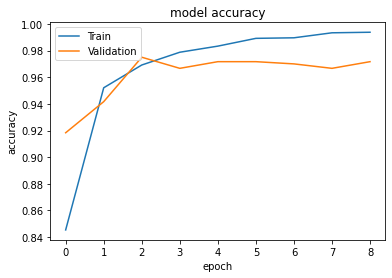

In [22]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

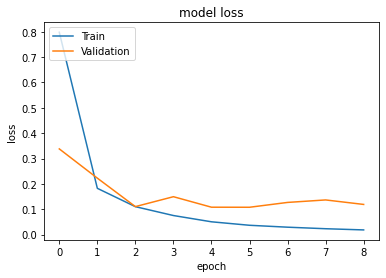

In [23]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Convert Model ke TF-Lite

In [24]:
export_dir = 'saved_model/'
tf.saved_model.save(model, export_dir)

In [25]:
import pathlib
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
tflite_model = converter.convert()

tflite_model_file = pathlib.Path('hasil.tflite')
tflite_model_file.write_bytes(tflite_model)

58874772